In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:

x0 = 5**(-8)
sigma = 1*10**(-10)
k = 5 * 10**10
def psi_0(Num_a):
    psi = np.exp(-(Num_a - x0)**2/(2*(sigma)**2))*np.exp(1j*k*Num_a)
    return psi

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


mpl.rcParams['animation.embed_limit'] = 100

L = 1e-8
N = 1000
a = L / N
x = np.linspace(a, L, N)

x0 = 1e-8 / 2
sigma = 1e-10
k = 5e10

def psi_0(x_val):
    return np.exp(-(x_val - x0)**2 / (2 * sigma**2)) * np.exp(1j * k * x_val)

psi_init = np.array([psi_0(xi) * 10**(-9) for xi in x], dtype=complex)


psi_init[0]  = 0.0
psi_init[-1] = 0.0


h = 1e-18
h_bar = 1.05457e-34
m = 9.1094e-31


a1 = 1 + h * (1j * h_bar) / (2 * m * a**2)
a2 = -h * (1j * h_bar) / (4 * m * a**2)

b1 = 1 - h * (1j * h_bar) / (2 * m * a**2)
b2 =  h * (1j * h_bar) / (4 * m * a**2)

dim = N



main_diag_A = a1 * np.ones(dim, dtype=complex)
off_diag_A  = a2 * np.ones(dim - 1, dtype=complex)

A = (np.diag(main_diag_A, k=0) +
     np.diag(off_diag_A, k=1) +
     np.diag(off_diag_A, k=-1))


v = np.zeros(N, dtype=complex)


def step_with_loop(psi):
    """
    Perform one Crank–Nicolson step: solve A ψ_new = v,
    where v = B ψ_old computed explicitly.
    """

    v[0] = b1 * psi[0] + b2 * psi[1]

    for i in range(1, N - 1):
        v[i] = b1 * psi[i] + b2 * (psi[i + 1] + psi[i - 1])

    v[N - 1] = b1 * psi[N - 1] + b2 * psi[N - 2]

    psi_new = np.linalg.solve(A, v)

    psi_new[0]  = 0.0
    psi_new[-1] = 0.0

    return psi_new


total_steps     = 5000
steps_per_frame = 5
n_frames        = total_steps // steps_per_frame

fig, ax = plt.subplots()

real_part_init = np.real(psi_init)
line, = ax.plot(x, real_part_init)

ax.set_xlabel("x (m)")
ax.set_ylabel(r"$\psi(x,t)$")
ax.set_xlim(x[0], x[-1])

max_amp = np.abs(psi_init).max()
ax.set_ylim(-1.2 * max_amp, 1.2 * max_amp)

ax.set_title("Time evolution of wavefunction, step = 0")

state = {"psi": psi_init.copy()}

def init():
    state["psi"] = psi_init.copy()   # reset to t = 0
    line.set_ydata(np.real(state["psi"]))
    ax.set_title("Time evolution of wavefunction, step = 0")
    return line,


def update(frame_idx):

    for _ in range(steps_per_frame):
        state["psi"] = step_with_loop(state["psi"])

    line.set_ydata(np.real(state["psi"]))

    current_step = (frame_idx + 1) * steps_per_frame
    ax.set_title(f"Time evolution of wavefunction, step = {current_step}")
    return line,

ani = FuncAnimation(
    fig,
    update,
    frames=n_frames,
    init_func=init,
    interval=30,
    blit=True
)
ani.save("wavefunction.mp4", writer="ffmpeg", fps=30)

HTML(ani.to_jshtml())

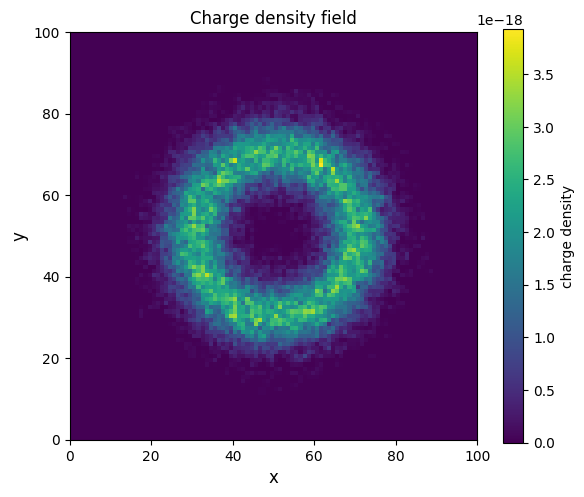

In [ ]:

particles = np.loadtxt("particles.dat")

Lx = 100.0
Ly = 100.0
Nx = 100
Ny = 100

dx = Lx / Nx
dy = Ly / Ny

rho = np.zeros((Ny, Nx), dtype=float)
q = 1.6*10**(-19)


xs = particles[:, 0]
ys = particles[:, 1]

for x, y in zip(xs, ys):

    gx = x / dx
    gy = y / dy

    i = int(np.floor(gx))
    j = int(np.floor(gy))


    if i < 0:
        i = 0
    if i > Nx - 2:
        i = Nx - 2
    if j < 0:
        j = 0
    if j > Ny - 2:
        j = Ny - 2

    fx = gx - i
    fy = gy - j

    w00 = (1 - fx) * (1 - fy)
    w10 = fx       * (1 - fy)
    w01 = (1 - fx) * fy
    w11 = fx       * fy

    rho[j,   i  ] += q * w00
    rho[j,   i+1] += q * w10
    rho[j+1, i  ] += q * w01
    rho[j+1, i+1] += q * w11

rho /= (dx * dy)

plt.figure(figsize=(6, 5))
im = plt.imshow(
    rho,
    origin='lower',
    extent=[0, Lx, 0, Ly],
    aspect='equal'
)
plt.colorbar(im, label='charge density')
plt.xlabel('x',fontsize = 12)
plt.ylabel('y', fontsize = 12)
plt.title('Charge density field')
plt.tight_layout()
plt.savefig("chare-density-field")
plt.show()


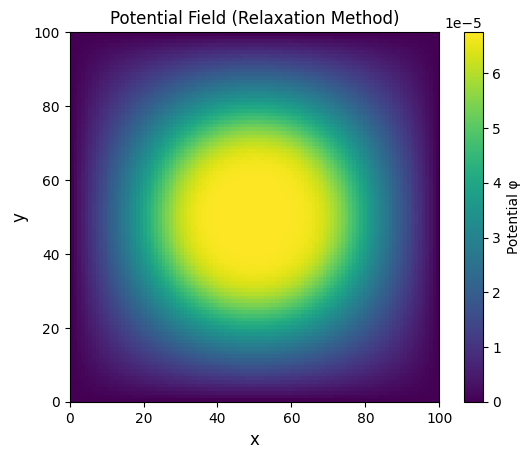

11850


In [ ]:
M = 100
L = 100
dx = L / M
target = 1e-10

phi = np.zeros((M+1, M+1), float)
phiprime = np.zeros_like(phi)

delta = 1.0

epsilon_0 = 8.85*10**(-12)
charge = 1.6*10**(-19)



iterations = 0
while delta > target and iterations < 50000:
  iterations += 1

  for i in range(1, M):
      for j in range(1, M):
          phiprime[i, j] = 0.25 * (phi[i+1, j] + phi[i-1, j] +phi[i, j+1] + phi[i, j-1]) + 0.25 * dx**2 / epsilon_0 * rho[i, j]


  delta = np.max(np.abs(phiprime - phi))
  phi, phiprime = phiprime, phi

plt.imshow(phi, origin='lower', extent=[0, 100, 0, 100])
plt.colorbar(label="Potential φ")
plt.xlabel("x",fontsize = 12)
plt.ylabel("y", fontsize = 12)
plt.title("Potential Field (Relaxation Method)", fontsize = 12)
plt.show()
print(iterations)

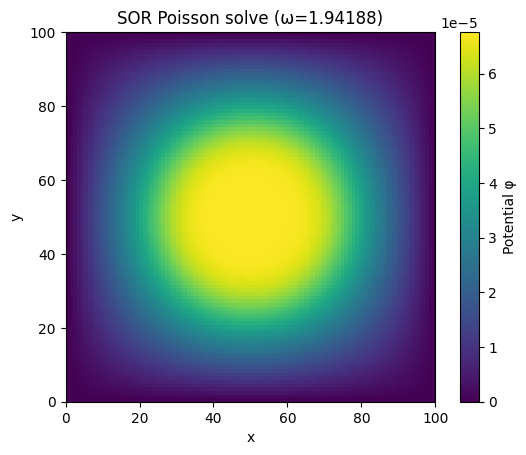

203


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


M = 100
L = 100.0
dx = L / M
target = 1e-10

epsilon_0 = 8.865*10**(-12)
omega = 1.94188


phi = np.zeros((M+1, M+1), float)


def solve_w_omega(omega):
  delta = 1.0
  iteration = 0

  while delta > target:
      delta = 0.0

      for i in range(1, M):
          for j in range(1, M):
              phi_J = 0.25 * (
                  phi[i+1, j] + phi[i-1, j] +
                  phi[i, j+1] + phi[i, j-1] +
                  dx**2 / epsilon_0 * rho[i, j]
              )

              old = phi[i, j]
              phi[i, j] = (1 - omega) * old + omega * phi_J

              diff = abs(phi[i, j] - old)
              if diff > delta:
                  delta = diff

      iteration += 1
  return phi,iteration


phi,iteration = solve_w_omega(omega)
plt.imshow(phi, origin='lower', extent=[0, 100, 0, 100])
plt.colorbar(label="Potential φ")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"SOR Poisson solve (ω={omega})")
plt.show()
print(iteration)


<>:101: SyntaxWarning: invalid escape sequence '\o'
<>:101: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-463754838.py:101: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('$1/2(\omega_2+\omega_3)$',fontsize = 12)


Starting Golden Section Search...
Optimal Omega Found: 1.94177
Iterations Required: 203
Theoretical Omega:   1.93909


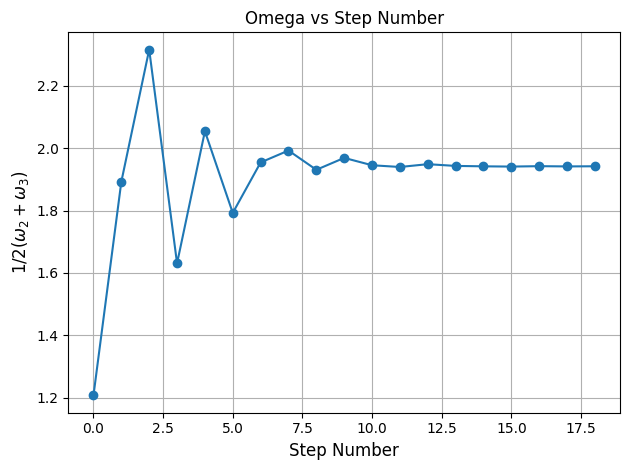

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

M = 100
L = 100.0
dx = L / M
target = 1e-10
epsilon_0 = 8.865e-12


@jit(nopython=True)
def solve_w_omega(omega, rho, max_iter=50000):
    phi = np.zeros((M+1, M+1), np.float64)
    delta = 1.0
    iteration = 0

    rho_term = dx**2 / epsilon_0

    while delta > target and iteration < max_iter:
        delta = 0.0

        for i in range(1, M):
            for j in range(1, M):
                phi_J = 0.25 * (
                    phi[i+1, j] + phi[i-1, j] +
                    phi[i, j+1] + phi[i, j-1] +
                    rho_term * rho[i, j]
                )

                old = phi[i, j]
                phi[i, j] = (1 - omega) * old + omega * phi_J

                diff = np.abs(phi[i, j] - old)
                if diff > delta:
                    delta = diff

        iteration += 1

    return phi, iteration

def golden_search_with_tracking(rho, a=0.1, b=3, tol=0.001):
    gr = (np.sqrt(5) - 1) / 2
    c = b - gr * (b - a)
    d = a + gr * (b - a)

    history_omega = []
    history_iters = []

    _, fc = solve_w_omega(c, rho)
    history_omega.append(c)
    history_iters.append(fc)

    _, fd = solve_w_omega(d, rho)
    history_omega.append(d)
    history_iters.append(fd)

    while abs(b - a) > tol:
        if fc < fd:
            b = d
            d = c
            fd = fc
            c = b - gr * (b - a)

            _, fc = solve_w_omega(c, rho)
            history_omega.append(c)
            history_iters.append(fc)
        else:
            a = c
            c = d
            fc = fd
            d = a + gr * (b - a)

            _, fd = solve_w_omega(d, rho)
            history_omega.append(d)
            history_iters.append(fd)

    if fc < fd:
        return c, fc, history_omega, history_iters
    else:
        return d, fd, history_omega, history_iters

print("Starting Golden Section Search...")
best_omega, best_iters, h_omega, h_iters = golden_search_with_tracking(rho, a=0.1, b=3, tol=0.001)

theoretical_omega = 2 / (1 + np.sin(np.pi / M))

print(f"Optimal Omega Found: {best_omega:.5f}")
print(f"Iterations Required: {best_iters}")
print(f"Theoretical Omega:   {theoretical_omega:.5f}")


steps = np.arange(len(h_omega))
plt.plot(steps, h_omega, 'o-', label='Tested Omega')
plt.xlabel('Step Number',fontsize = 12)
plt.ylabel('$1/2(\omega_2+\omega_3)$',fontsize = 12)
plt.title('Omega vs Step Number', fontsize = 12)
plt.grid(True)

plt.tight_layout()
plt.show()